In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/google-stock-price/Google_Stock_Price_Test.csv
/kaggle/input/google-stock-price/Google_Stock_Price_Train.csv


# Data Review <a id = "1"></a>
[Go Content](#cont)

I read the dataset with the panda library.

In [3]:
data = pd.read_csv("/kaggle/input/google-stock-price/Google_Stock_Price_Train.csv")
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
# information of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [5]:
# Dataset Values(Max, min, std..)
data.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [6]:
# Data Correlation: Relationship between columns
data.corr()

,Open,High,Low
Open,1.000000,0.999692,0.999498
High,0.999692,1.000000,0.999480
Low,0.999498,0.999480,1.000000


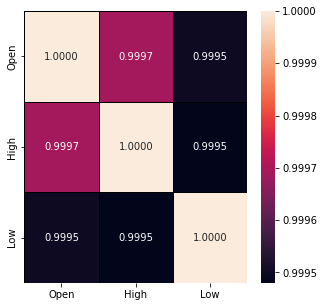

In [7]:
# Visualization of correlation result with seaborn library heatmap.
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(data.corr(), annot = True, linewidths=0.5, linecolor = "black", fmt = ".4f", ax = ax)
plt.show()

In the above section, I look at the relationship between columns of type float64. I tried to change the Close and Volume columns but I got an error because there were unchanging data in these columns.

In [8]:
# Dataset columns names
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

# Data Prepare <a id = "2"></a>
[Go Content](#cont)

I separate the data from which I will apply the RNN model from the dataset.

In [9]:
data_set = data.loc[:, ["Open"]].values
data_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

I constitute train and test from the data_set.

In [10]:
train = data_set[:len(data_set) - 50]
test = data_set[len(train):]

train.reshape(train.shape[0],1)
train.shape

(1208, 1)

- I normalize the train dataset.(between zero to one)
- I use the MinMaxScaler function of Sklearn Library.

In [11]:
# Normalization wiht MinmaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1)) # değerleri 0 ile 1 arasında sayılara indirger
train_scaler = scaler.fit_transform(train)
train_scaler

array([[0.08886192],
       [0.10045847],
       [0.09768454],
       ...,
       [0.96447835],
       [0.97998536],
       [1.        ]])

I visualize the train_scaler.

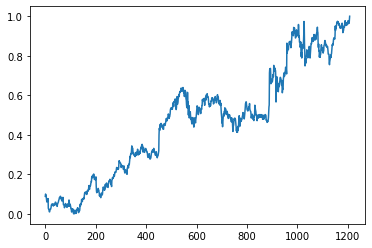

In [12]:
plt.plot(train_scaler)
plt.show()

I create a data structure with 50 timesteps and 1 output.

In [13]:
X_train = []
Y_train = []
timesteps = 50

for i in range(timesteps, len(train_scaler)):
    X_train.append(train_scaler[i - timesteps:i, 0])
    Y_train.append(train_scaler[i,0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)

# reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [14]:
X_train.shape

(1158, 50, 1)

In [15]:
X_train

array([[[0.08886192],
        [0.10045847],
        [0.09768454],
        ...,
        [0.03806442],
        [0.04646325],
        [0.05245415]],

       [[0.10045847],
        [0.09768454],
        [0.0948143 ],
        ...,
        [0.04646325],
        [0.05245415],
        [0.05399522]],

       [[0.09768454],
        [0.0948143 ],
        [0.08267838],
        ...,
        [0.05245415],
        [0.05399522],
        [0.05811758]],

       ...,

       [[0.9528818 ],
        [0.96871629],
        [0.96698259],
        ...,
        [0.97210664],
        [0.96721375],
        [0.96804207]],

       [[0.96871629],
        [0.96698259],
        [0.97208738],
        ...,
        [0.96721375],
        [0.96804207],
        [0.96447835]],

       [[0.96698259],
        [0.97208738],
        [0.9744953 ],
        ...,
        [0.96804207],
        [0.96447835],
        [0.97998536]]])

In [16]:
Y_train

array([0.05399522, 0.05811758, 0.06025582, ..., 0.96447835, 0.97998536,
       1.        ])

In [19]:
# Import Library 
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout

# Initialising the RNN
regressor = Sequential()

# Add the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Second RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

# Third RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

# Fourth RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Add the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = "adam", loss = "mean_squared_error")

# Fitting the RNN to the training set
regressor.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
37/37 [==============================] - 8s 117ms/step - loss: 0.3806
Epoch 2/20
37/37 [==============================] - 4s 118ms/step - loss: 0.3207
Epoch 3/20
37/37 [==============================] - 4s 120ms/step - loss: 0.2193
Epoch 4/20
37/37 [==============================] - 4s 120ms/step - loss: 0.2071
Epoch 5/20
37/37 [==============================] - 4s 118ms/step - loss: 0.1470
Epoch 6/20
37/37 [==============================] - 4s 117ms/step - loss: 0.1207
Epoch 7/20
37/37 [==============================] - 5s 132ms/step - loss: 0.0993
Epoch 8/20
37/37 [==============================] - 4s 116ms/step - loss: 0.0834
Epoch 9/20
37/37 [==============================] - 4s 114ms/step - loss: 0.0696
Epoch 10/20
37/37 [==============================] - 4s 117ms/step - loss: 0.0577
Epoch 11/20
37/37 [==============================] - 4s 112ms/step - loss: 0.0528
Epoch 12/20
37/37 [==============================] - 4s 114ms/step - loss: 0.0484
Epoch 13/20
37/37 [======

## Predictions And Visualising RNN Model <a id = "4"></a>
[Go Content](#cont)

In this chapter, I will check result about RNN model.

I prepare the test dataset.

In [20]:
inputs = data_set[len(data_set) - len(test) - timesteps:]
inputs = scaler.transform(inputs)

In [21]:
X_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i - timesteps:i, 0])
    
X_test_rnn = np.array(X_test)
X_test_rnn = np.reshape(X_test_rnn, (X_test_rnn.shape[0], X_test_rnn.shape[1], 1))
predicted_stock_price = regressor.predict(X_test_rnn)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

I visualize the training result of the test dataset.

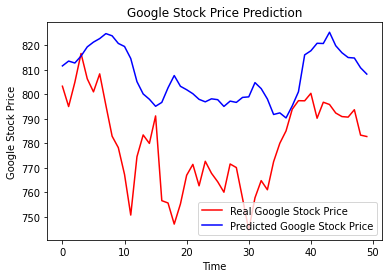

In [22]:
# visualising the results
plt.plot(test, color = "red", label = "Real Google Stock Price 2017")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted Google Stock Price 2017")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()
plt.show()

## Create And Training LSTM Model <a id = "6"></a>
[Go Content](#cont)

I will prepare the dataset and I will do to train with the LSTM model.

I prepare trainX dataset for LSTM model. I just change its shape.

In [23]:
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [24]:
# Import Library For LSTM Model
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

I create the LSTM model and I start the training.

In [26]:
model = Sequential()
model.add(LSTM(10, input_shape = (1, timesteps)))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")
model.fit(trainX, Y_train, epochs = 10, batch_size = 1)

Epoch 1/10
1158/1158 [==============================] - 4s 2ms/step - loss: 0.0068
Epoch 2/10
1158/1158 [==============================] - 2s 2ms/step - loss: 0.0016
Epoch 3/10
1158/1158 [==============================] - 2s 2ms/step - loss: 0.0013
Epoch 4/10
1158/1158 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 5/10
1158/1158 [==============================] - 2s 2ms/step - loss: 0.0010
Epoch 6/10
1158/1158 [==============================] - 2s 2ms/step - loss: 9.0218e-04
Epoch 7/10
1158/1158 [==============================] - 2s 2ms/step - loss: 9.1541e-04
Epoch 8/10
1158/1158 [==============================] - 2s 2ms/step - loss: 8.5600e-04
Epoch 9/10
1158/1158 [==============================] - 2s 2ms/step - loss: 7.5790e-04
Epoch 10/10
1158/1158 [==============================] - 2s 2ms/step - loss: 7.8449e-04


## Predictions And Visualising LSTM Model <a id = "7"></a>
[Go Content](#cont)

In this chapter, I will check result about LSTM model.

In [27]:
# Prepare test dataset
testX = np.array(X_test)
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

# Predict with testX
predict_lstm = model.predict(testX)
predict_lstm = scaler.inverse_transform(predict_lstm)

I visualize the training result of the test dataset.

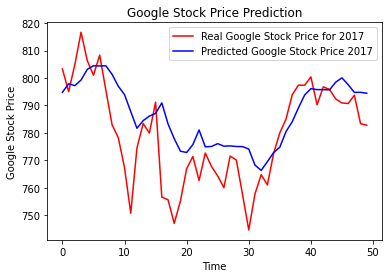

In [29]:
# visualising the results
plt.plot(test, color = "red", label = "Real Google Stock Price for 2017")
plt.plot(predict_lstm, color = "blue", label = "Predicted Google Stock Price 2017")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()
plt.show()

# CONCLUSION <a id = "8"></a>
****
The LSTM model predicts the stock price better than the Simple RNN model.